In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf  # For tf.data
import keras
from keras import layers

import matplotlib.pyplot as plt


from numba import jit, cuda

In [ ]:
with open("/content/drive/MyDrive/Dataset/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
points_dir = "/content/drive/MyDrive/Dataset/points"
labels_dir = "/content/drive/MyDrive/Dataset/points_label"
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 100
INITIAL_LR = 1e-3

In [ ]:
print(LABELS)
print(COLORS)

['wing', 'body', 'tail', 'engine']
['blue', 'green', 'red', 'pink']


In [ ]:
import os

def count_files_in_folder(folder_path):
    try:
        # List all files in the specified folder
        files = os.listdir(folder_path)

        # Count the number of files
        num_files = len(files)

        print(f"Number of files in '{folder_path}': {num_files}")

    except FileNotFoundError:
        print(f"The specified folder '{folder_path}' does not exist.")
    except PermissionError:
        print(f"Permission error while accessing the folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Specify the folder path
folder_path = '/content/pointss'

# Call the function to count files in the specified folder
count_files_in_folder(folder_path)

Number of files in '/content/pointss': 811


In [ ]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []


points_files = glob(os.path.join(points_dir, "*.pts"))

for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)



100%|██████████| 4045/4045 [1:33:31<00:00,  1.39s/it]


In [ ]:
len(point_clouds)

3694

In [ ]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[3251].shape: (2617, 3)
point_cloud_labels[3251].shape: (2617, 5)
all_labels[3251][0]: none 	point_cloud_labels[3251][0]: [0. 0. 0. 0. 1.] 

all_labels[3251][1]: body 	point_cloud_labels[3251][1]: [0. 1. 0. 0. 0.] 

all_labels[3251][2]: body 	point_cloud_labels[3251][2]: [0. 1. 0. 0. 0.] 

all_labels[3251][3]: body 	point_cloud_labels[3251][3]: [0. 1. 0. 0. 0.] 

all_labels[3251][4]: none 	point_cloud_labels[3251][4]: [0. 0. 0. 0. 1.] 

point_clouds[3440].shape: (2617, 3)
point_cloud_labels[3440].shape: (2617, 5)
all_labels[3440][0]: engine 	point_cloud_labels[3440][0]: [0. 0. 0. 1. 0.] 

all_labels[3440][1]: body 	point_cloud_labels[3440][1]: [0. 1. 0. 0. 0.] 

all_labels[3440][2]: wing 	point_cloud_labels[3440][2]: [1. 0. 0. 0. 0.] 

all_labels[3440][3]: body 	point_cloud_labels[3440][3]: [0. 1. 0. 0. 0.] 

all_labels[3440][4]: tail 	point_cloud_labels[3440][4]: [0. 0. 1. 0. 0.] 

point_clouds[492].shape: (2617, 3)
point_cloud_labels[492].shape: (2617, 5)
all_labels[492][

In [ ]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


In [ ]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 3694/3694 [00:09<00:00, 386.13it/s]


In [ ]:
len(current_label_cloud)

2571

In [ ]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.001, 0.001, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 2955
Num train point cloud labels: 2955
Num val point clouds: 739
Num val point cloud labels: 739
Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float64, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float64, name=None))>


In [ ]:
def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x, filters, name):
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = keras.ops.eye(num_features)

    def __call__(self, x):
        x = keras.ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = keras.ops.tensordot(x, x, axes=(2, 2))
        xxt = keras.ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return keras.ops.sum(self.l2reg * keras.ops.square(xxt - self.identity))

    def get_config(self):
        config = super().get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

In [ ]:
def transformation_net(inputs, num_features, name):
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [ ]:
def get_shape_segmentation_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = keras.ops.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

In [ ]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None, 3)        │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │        256 │ input_layer_4[0][0]        │
│ (Conv1D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │        256 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │          0 │ input_transformation_bloc… │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │      8,320 │ input_transformation_bloc… │
│ (Conv1D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │        512 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │          0 │ input_transformation_bloc… │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │    132,096 │ input_transformation_bloc… │
│ (Conv1D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │      4,096 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │          0 │ input_transformation_bloc… │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ global_max_pooling1d_8    │ (None, 1024)           │          0 │ input_transformation_bloc… │
│ (GlobalMaxPooling1D)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │    524,800 │ global_max_pooling1d_8[0]… │
│ (Dense)                   │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │      2,048 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├──────────────────────

 Total params: 7,370,062 (28.11 MB)

 Trainable params: 7,356,110 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

Steps per epoch: 92.
Total training steps: 9200.


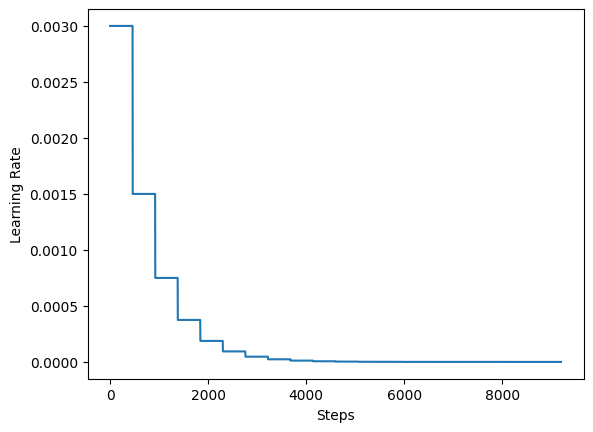

In [ ]:
steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
def run_experiment(epochs):
  with tf.device('/gpu:0'):
      segmentation_model = get_shape_segmentation_model(num_points, num_classes)
      segmentation_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
          loss=keras.losses.CategoricalCrossentropy(),
          metrics=["accuracy"],
      )

      checkpoint_filepath = "checkpoint.weights.h5"
      checkpoint_callback = keras.callbacks.ModelCheckpoint(
          checkpoint_filepath,
          monitor="val_loss",
          save_best_only=True,
          save_weights_only=True,
      )

      history = segmentation_model.fit(
          train_dataset,
          validation_data=val_dataset,
          epochs=epochs,
          callbacks=[checkpoint_callback],
      )

      segmentation_model.load_weights(checkpoint_filepath)
      return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 422ms/step - accuracy: 0.3746 - loss: 36938.5312 - val_accuracy: 0.4472 - val_loss: 736000.1875
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.5449 - loss: 202.2796 - val_accuracy: 0.5309 - val_loss: 950647.1875
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.6114 - loss: 191.3174 - val_accuracy: 0.4427 - val_loss: 734612.0625
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.6481 - loss: 185.1582 - val_accuracy: 0.4700 - val_loss: 232764.4219
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.6533 - loss: 180.8791 - val_accuracy: 0.4614 - val_loss: 977.7791
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.6569 - loss: 175.0045 - val_accuracy: 0.5402 - val_loss: 1458.8101
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.6577 - loss: 177.4762 - val_accuracy: 0.4028 - val_loss: 6769.5024
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 222

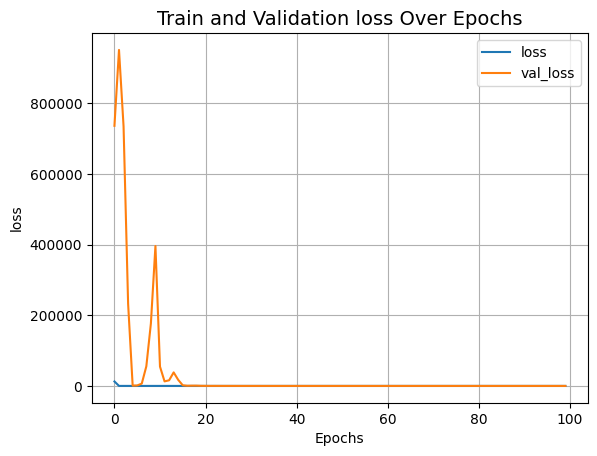

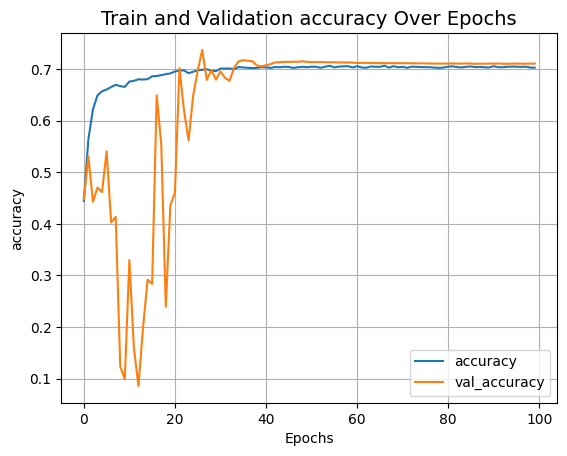

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [1]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

NameError: ignored